In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
from sklearn.calibration import calibration_curve

import auxil_ML as aux
import plotting

In [2]:
def get_reliability0(y_true, y_prob, bins):
    """
        y_prob - probability for prediction of the class
        y_true - 1 if element belongs to the class, 0 otherwise
        bins - grid
    """
    prob_true = np.zeros(len(pgrid) - 1)
    prob_pred = np.zeros(len(pgrid) - 1)
    for i in range(len(bins) - 1):
        mask = (y_prob > bins[i]) & (y_prob < bins[i+1])
        prob_true[i] = np.mean(y_true[mask])
        prob_pred[i] = np.mean(y_prob[mask])
    return prob_true, prob_pred


def get_reliability1(y_true, y_prob, bins):
    """
        pgrid - grid of probabilities
        probs - probability for prediction of the class
        labels - 1 if element belongs to the class, 0 otherwise
    """
    nelem = np.histogram(y_prob, bins=bins)[0]
    prob_true = np.histogram(y_prob, bins=bins, weights=y_true)[0] / nelem
    prob_pred = np.histogram(y_prob, bins=bins, weights=y_prob)[0] / nelem
    return prob_true, prob_pred
    
get_reliability = get_reliability1

In [106]:
two_class_all = 1
cat = '3FGL'
if cat == '4FGL':
    cat_name = '4FGL-DR2'
else:
    cat_name = cat
cat_fn = '../SOM/%s_prob_catalog_3classes.csv' % cat_name
cat_df3 = pd.read_csv(cat_fn, index_col=0)
cat_fn = '../SOM/%s_prob_catalog_2classes.csv' % cat_name
cat_df2 = pd.read_csv(cat_fn, index_col=0)


In [107]:
pgrid = np.arange(0, 1.000001, 0.1)
pgrid_c = (pgrid[1:] + pgrid[:-1]) / 2
algs = ['RF', 'BDT', 'NN', 'LR']
algs_o = [alg + '_O' for alg in algs]
pop = 'AGN'
my_calc = 0 # use my function for calibration curve, otherwise use the function from sklearn

mrks = ['s', 'o', 'd', 'v']
plots = ['n', 'o']
#plots = ['n']
plotting.setup_figure_pars()
save_plots = 0
plots_folder1 = 'plots/calibration/'
plots_folder2 = '../ML_3FGL_paper/plots/reliability/'

In [108]:
# 3 class - reliability for all associated sources
prob_pred = {}
prob_true = {}
err = {}
chi2_3class = {}
select_mask = cat_df3['Category_%s' % cat] != 'UNAS'
labels = cat_df3[select_mask]['Category_%s' % cat] == pop
y_true = np.array(labels, dtype=float)
for alg in algs + algs_o:
    #print(alg)
    y_prob = cat_df3[select_mask]['%s_%s' % (pop, alg)]
    if not my_calc:
        prob_true[alg], prob_pred[alg] = calibration_curve(y_true, y_prob, n_bins=10)
    else:
        prob_true[alg], prob_pred[alg] = get_reliability(y_true, y_prob, pgrid)
        if 1:
            # compare my calculation with sklearn function
            prob_true_c, prob_pred_c = calibration_curve(y_true, y_prob, n_bins=10)
            print(prob_true[alg] - prob_true_c)
            print(prob_pred[alg] - prob_pred_c)
            #break
    ntotal = np.histogram(y_prob, bins=pgrid)[0][:len(prob_true[alg])]
    err[alg] = np.sqrt(ntotal * prob_true[alg]) / ntotal
    chi2_3class[alg] = (prob_true[alg] - prob_pred[alg])**2 / err[alg]**2

/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide
/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide
/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide


In [109]:
#print(prob_true)

In [110]:
if 0:
    binids = np.digitize(probs, pgrid) - 1
    print(binids[100:])
    print(probs)

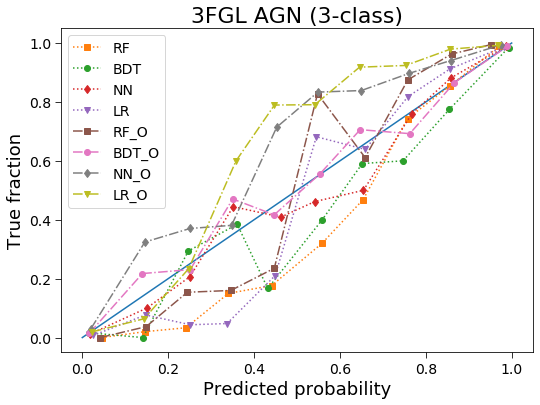

In [111]:

pyplot.figure()
pyplot.plot(pgrid, pgrid)
if 'n' in plots:
    for i, alg in enumerate(algs):
        #pyplot.errorbar(prob_pred[alg], prob_true[alg], err[alg], ls=':', marker=mrks[i], label=alg)
        pyplot.plot(prob_pred[alg], prob_true[alg], ls=':', marker=mrks[i], label=alg)
if 'o' in plots:
    for i, alg in enumerate(algs_o):
        #pyplot.errorbar(prob_pred[alg], prob_true[alg], err[alg], ls='-.', marker=mrks[i], label=alg)
        pyplot.plot(prob_pred[alg], prob_true[alg], ls='-.', marker=mrks[i], label=alg)
pyplot.xlabel('Predicted probability')
pyplot.ylabel('True fraction')
pyplot.title('%s %s (3-class)' % (cat_name, pop))
pyplot.legend()

if save_plots:
    fn = 'calibration_%s_%s_3classes.pdf' % (pop, cat_name)
    print('save figure to file: %s' % (plots_folder1 + fn))
    pyplot.savefig(plots_folder1 + fn)
    print('save figure to file: %s' % (plots_folder2 + fn))
    pyplot.savefig(plots_folder2 + fn)



In [112]:
if pop != 'OTHER':
    chi2_2class = {}
    # 2 class - reliability for PSRs and AGNs only
    if two_class_all:
        select_mask = cat_df2['Category_%s' % cat] != 'UNAS'
    else:
        select_mask = (cat_df2['Category_%s' % cat] == 'PSR') | (cat_df2['Category_%s' % cat] == 'AGN')
    labels = cat_df2[select_mask]['Category_%s' % cat] == pop
    y_true = np.array(labels, dtype=float)
    for alg in algs + algs_o:
        y_prob = cat_df2[select_mask]['%s_%s' % (pop, alg)]
        if not my_calc:
            prob_true[alg], prob_pred[alg] = calibration_curve(y_true, y_prob, n_bins=10)
        else:
            prob_true[alg], prob_pred[alg] = get_reliability(y_true, y_prob, pgrid)
        ntotal = np.histogram(y_prob, bins=pgrid)[0]
        err[alg] = np.sqrt(ntotal * prob_true[alg]) / ntotal
        chi2_2class[alg] = (prob_true[alg] - prob_pred[alg])**2 / err[alg]**2

/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


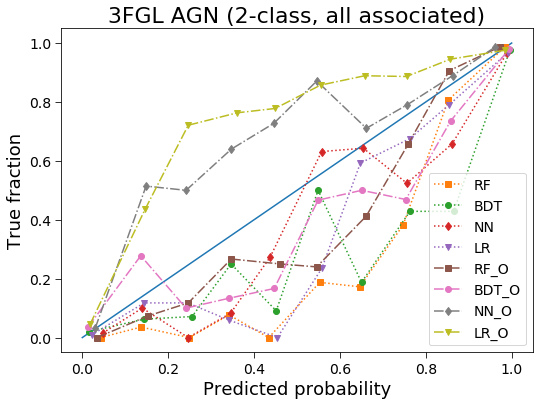

In [113]:
if pop != 'OTHER':
    pyplot.figure()
    pyplot.plot(pgrid, pgrid)
    if 'n' in plots:
        for i, alg in enumerate(algs):
            #pyplot.errorbar(prob_pred[alg], prob_true[alg], err[alg], ls=':', marker=mrks[i], label=alg)
            pyplot.plot(prob_pred[alg], prob_true[alg], ls=':', marker=mrks[i], label=alg)
    if 'o' in plots:
        for i, alg in enumerate(algs_o):
            #pyplot.errorbar(prob_pred[alg], prob_true[alg], err[alg], ls='-.', marker=mrks[i], label=alg)
            pyplot.plot(prob_pred[alg], prob_true[alg], ls='-.', marker=mrks[i], label=alg)

    pyplot.xlabel('Predicted probability')
    pyplot.ylabel('True fraction')
    if two_class_all:
        title = '%s %s (2-class, all associated)' % (cat_name, pop)
    else:
        title = '%s %s (2-class, AGN + PSR)' % (cat_name, pop)
    pyplot.title(title)
    pyplot.legend()

    if save_plots:
        if two_class_all:
            fn = 'calibration_%s_%s_2classes_all_assoc.pdf' % (pop, cat_name)
        else:
            fn = 'calibration_%s_%s_2classes_AGN_PSR.pdf' % (pop, cat_name)
        print('save figure to file: %s' % (plots_folder1 + fn))
        pyplot.savefig(plots_folder1 + fn)
        print('save figure to file: %s' % (plots_folder2 + fn))
        pyplot.savefig(plots_folder2 + fn)


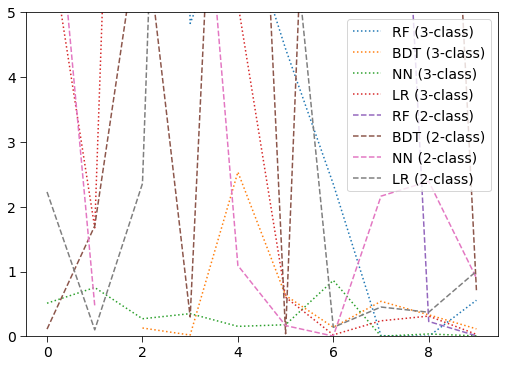

In [114]:
pyplot.figure()
for alg in algs:
    pyplot.plot(chi2_3class[alg], ls=':', label='%s (3-class)' % alg)
for alg in algs:
    pyplot.plot(chi2_2class[alg], ls='--', label='%s (2-class)' % alg)
pyplot.ylim(0, 5)
pyplot.legend()